In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import scipy.stats as st
import plotly.express as px
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from scipy.stats import bartlett
from scipy.stats import kruskal


## Corrélation sans les clients bussiness
### Variable quali / quanti
###  

In [2]:
t_b2b= pd.read_csv('/home/david/OC/P6_Terrasson_David/cours_annexes/t_b2b.csv',index_col='date')
t_b2c= pd.read_csv('/home/david/OC/P6_Terrasson_David/cours_annexes/t_b2c.csv',index_col='date')
global_t= pd.read_csv('/home/david/OC/P6_Terrasson_David/cours_annexes/global_t.csv',index_col='date')
global_t_client= pd.read_csv('/home/david/OC/P6_Terrasson_David/cours_annexes/global_t_client.csv')

In [3]:
sns.set( 
    style='whitegrid',
    context='notebook',
    palette=['#c2a87c','#423217','#8F7C5B','#423A2A','#CC9B45'],
    rc={'figure.figsize':(14,6),'axes.facecolor':'grey', 'figure.facecolor':'grey'})

In [4]:
X = "categ" # qualitative
Y = "age" # quantitative

In [5]:
def proportion (categ) :
    categ = categ/ccategorie["total"]
    return categ

In [6]:
business =['c_1609','c_6714','c_3454','c_4958']
transactions_b2c= global_t[~global_t['client_id'].isin(business)]
transactions_b2c.head(2)

session_id  month  month_part  weekday  hour  \
date                                                                      
2021-03-22 01:40:22.782925     s_9707      3           2        0     1   
2023-02-22 01:40:22.782925   s_345108      2           2        2     1   

                           client_id sex   age age_group product_id  price  \
date                                                                         
2021-03-22 01:40:22.782925    c_4410   f  55.0     51-70      1_385  25.99   
2023-02-22 01:40:22.782925    c_4410   f  55.0     51-70      1_385  25.99   

                           price_group  categ  
date                                           
2021-03-22 01:40:22.782925           L    1.0  
2023-02-22 01:40:22.782925           L    1.0

## Réalisez une ANOVA à 1 facteur

On veut étudier ici l'influence de la catégorie sur l'âge .

On peut visualiser l'influence en affichant ces boîtes à moustaches :

### Étudier l'influence de la catégorie sur l'âge en utilisant des boxplot
### 


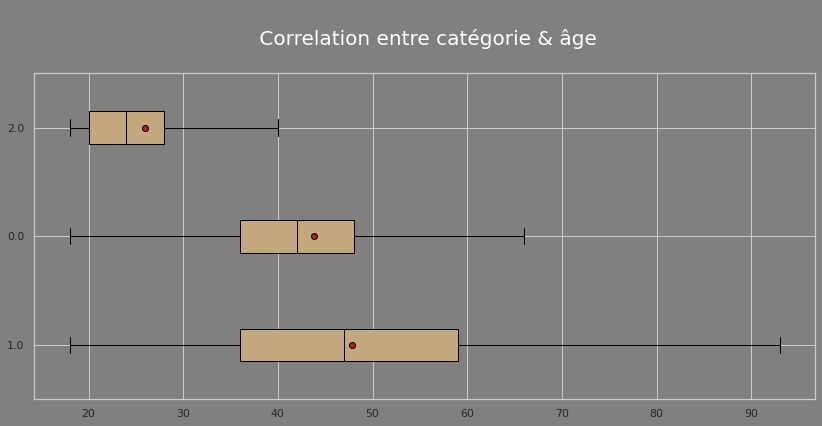

In [7]:
modalites = transactions_b2c[X].unique()
groupes = []
for m in modalites:
    groupes.append(transactions_b2c[transactions_b2c[X]==m][Y])
order=["0.0","1.0","2.0"] 
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes,labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('\n Correlation entre catégorie & âge\n',fontsize=20,color="white") # titre
plt.savefig('Correlation entre catégorie & âge', dpi=300, bbox_inches='tight')
plt.show()

### ANOVA a 1 facteur
### 

H0 : La catégorie n'a pas d'incidence sur l'âge > 5%

H1 : La catégorie a eu un incidence sur l'âge  < 5%

In [8]:
anova_variete = smf.ols('categ~age', data=transactions_b2c).fit()
anova_variete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  categ   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4524.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:38:56   Log-Likelihood:            -5.6354e+05
No. Observations:              632689   AIC:                         1.127e+06
Df Residuals:                  632687   BIC:                         1.127e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5987      0.002    241.361      0.000       0.594       0.604
age           -0.0036   5.35e-05    -67.259      0.000      -0.004      -0.003
==============================================================================
Omnibus:                    68095.682   Durbin-Watson:                   0.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            88734.038
Skew:                           0.903   Prob(JB):                         0.00
Kurtosis:                       2.672   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###       Réaliser un test de Fisher pour connaitre la corrélation,



A travers l'analyse de la variance on cherche à déterminer si :

H0 : Les moyennes de chaque catégorie sont égales si p-value > 5%

H1 : Les moyennes de chaque catégorie ne sont pas toutes égales < 5%

In [9]:
sm.stats.anova_lm(anova_variete, typ=2)

sum_sq        df            F  PR(>F)
age         1572.866227       1.0  4523.803934     0.0
Residual  219976.822363  632687.0          NaN     NaN

On fait un test de Fisher. La p-valeur de ce test ( 0.00) est inférieure à 5 %.

On rejette donc l'hypothèse H0, la catégorie a une incidence sur l'âge.

### L'indépendance ###
### 

In [10]:
transactions_b2c.groupby("categ")['age'].agg('var')

categ
0.0    132.612743
1.0    249.434712
2.0     98.007304
Name: age, dtype: float64

### L’égalité des variances : Bartlett
### 

In [11]:
bartlett(transactions_b2c.age[transactions_b2c.categ == 0.0],
        transactions_b2c.age[transactions_b2c.categ == 1.0],
        transactions_b2c.age[transactions_b2c.categ == 2.0])

BartlettResult(statistic=33008.91033420224, pvalue=0.0)

~H0 : Les variances de chaque groupe sont égales si p-value > 5%~

H1 : Les variances de chaque groupe ne sont pas toutes égales < 5%

### Normalité des résidus : Shapiro-Wilk 
### 


On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

H0 : Les résidus suivent une loi normale si p-value > 5%

H1 : Les résidus ne suivent pas une loi normale si p-value < 5%

In [12]:
model = ols('categ ~age ', data=transactions_b2c.sample(5000)).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.7408973574638367, pvalue=0.0)

~H0 : Les résidus suivent une loi normale si p-value > 5%~

H1 : Les résidus ne suivent pas une loi normale si p-value < 5%

### Test ANOVA non validé : Kruskal_Wallis

### 

In [13]:

stat, p = kruskal(transactions_b2c['categ'], transactions_b2c['age'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p> 0.05:
    print("Probablement independente :")
    print(f"Probablement la variable catégorie n'est pas liée à la variable âge")
else:
    print("Probablement dependente :")
    print(f"Probablement la variable «catégorie » est liée à la variable « âge»")

stat=981974.882, p=0.000
Probablement dependente :
Probablement la variable «catégorie » est liée à la variable « âge»


###  Eta_squared » pour tester la corrélation entre les variables catégorie et l’âge
### 

Interpretation du coreffecient eta square:

Intensite de correlation

|\|r\|| Interpretation|
|-------|---------------|
|0.00 < 0.07| Faible|
|0.08 < 0.13 |Moyenne|
|0.14 plus | Forte|

In [14]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(transactions_b2c[X],transactions_b2c[Y])

0.11327525898268855

On obtient un résultat proche de 0.11, ce qui laisse penser qu'il y a effectivement une corrélation entre l'âge et leur catégorie. 

https://www.delftstack.com/fr/howto/matplotlib/stack-bar-plots-matplotlib/

https://stackoverflow.com/questions/71409131/how-to-set-fixed-color-ranges-with-seaborn-heatmap

https://asardell.github.io/statistique-python/

https://openclassrooms.com/fr/courses/4525326-realisez-des-modelisations-de-donnees-performantes/5754155-realisez-une-analyse-de-la-variance 

https://www.statology.org/eta-squared/
